# **Titanic's Shipwreck Survival Prediction (Beginner)**
In this notebook we will try to predict if someone survived to the disaster. This is my first notebook, so if anyone has any recommendations or tips let me know them in the comments. Enjoy it!

## **Best results : 0.836 with 10k-fold crossvalidation**

# Table of contents
1. Reproducible Functions
1. Import libraries and Reading the Dataset
1. Exploratory Data Analysis (EDA) with Data Visualization and Feature Engineering
1. Preparing the dataset for modeling
1. Modeling and best model choice
1. Creating the Submission File

# 1.-Reproducible functions

In [1]:
def splitfeatures(X):
  X_num=X.describe().columns
  X_cat=X.columns.difference(X_num)
  X_num=X_num.tolist()
  X_cat=X_cat.tolist()
  print("Numeric features:      ",X_num)
  print("Categorical features:  ",X_cat)

def numfeatures(X):
    return(X.describe().columns.tolist())

def catfeatures(X):
    X_num=X.describe().columns
    return(X.columns.difference(X_num).tolist())

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

def percent_value_counts(df, feature):
    percent = pd.DataFrame(round(df.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2))
    total = pd.DataFrame(df.loc[:,feature].value_counts(dropna=False))
    total.columns = ["Total"]
    percent.columns = ['Percent']
    return pd.concat([total, percent], axis = 1)

def unique_values_in_column(data,feature):
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

# 2.-Import libraries and Reading the Dataset

In [2]:
#Data Processing
import numpy as np 
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
sns.set(style="white")
%matplotlib inline
        
#Warnings
import warnings
warnings.filterwarnings("ignore")

### Reading the Dataset

In [3]:
train=pd.read_csv("/kaggle/input/titanic/train.csv")
test=pd.read_csv("/kaggle/input/titanic/test.csv")
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
264,265,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
337,338,1,1,"Burns, Miss. Elizabeth Margaret",female,41.0,0,0,16966,134.5000,E40,C
814,815,0,3,"Tomlin, Mr. Ernest Portage",male,30.5,0,0,364499,8.0500,NaN,S
770,771,0,3,"Lievens, Mr. Rene Aime",male,24.0,0,0,345781,9.5000,NaN,S
703,704,0,3,"Gallagher, Mr. Martin",male,25.0,0,0,36864,7.7417,NaN,Q


# 3.-Exploratory Data Analysis (EDA) with Data Visualization and Feature Engineering

The Dataset is divided by the following features:

Numeric features:
   *     PassengerID: Identifier for each passenger. This feature won´t have value for our model  (Continuous)
   *     Survived: Survival status of the passenger. 1=Survived 0=Deceased. This is the feature that we need to predict in the test set (Discrete)
   *     Pclass: Ticket class. 1=First Class  2=Second Class  3=Third Class  (Discrete)
   *     Age: Age of the passenger  (Continuous)
   *     SibSp: Number of siblings and spouses aboard  (Discrete)
   *     Parch: Number of parents and children aboard  (Discrete)
   *     Fare: Ticket Fare  (Continuous)
        
Categorical features:
   * Cabin: Cabin number. (Alphanumeric)
   * Embarked: Embarkation port. C=Cherbourg  Q=Queenstown  S=Southampton
   * Name: Title and name of the passenger
   * Sex: Male or Female
   * Ticket: Ticket number (Alphanumeric)

## Assumptions
Looking at the features we can have a few assumptions before the data analysis:

* Female passengers survived more than male passengers
* Children passengers tend to survive more
* Higher socio-economic status passengers survived more than lower ones
* Passengers who paid a higher fare tend to survive more

In [4]:
splitfeatures(train)
print("="*100)
splitfeatures(test)

Numeric features:       ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical features:   ['Cabin', 'Embarked', 'Name', 'Sex', 'Ticket']
Numeric features:       ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical features:   ['Cabin', 'Embarked', 'Name', 'Sex', 'Ticket']


In [5]:
train.info()
print("="*100)
print("="*100)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

Now that we know the numeric and categorical features, we need to know how are they distributed and as we can see above, there are some features with missing values so we will look at that too

### Train set

In [6]:
train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Palsson, Miss. Torborg Danira",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [7]:
missing_percentage(train)

,Total,Percent
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


### Test set

In [8]:
test.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Nakid, Mrs. Said (Waika Mary"" Mowad)""",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [9]:
missing_percentage(test)

,Total,Percent
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
Embarked,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


# Correlation between numeric features

In [10]:
print("Numeric features:")
numfeatures(train)

Numeric features:


['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

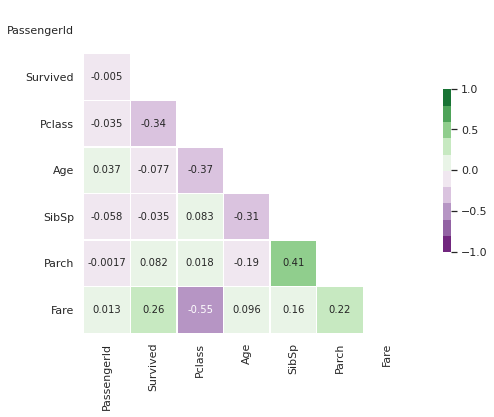

In [11]:
df_num=train[numfeatures(train)]
corr=df_num.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(12,6))
cmap = sns.color_palette("PRGn",10)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

# 3.1.-PassengerID Feature

Since we are not interested in this variable for our model, we are going to drop it from both train and test set

In [12]:
train.drop("PassengerId",axis=1,inplace=True)
test.drop("PassengerId",axis=1,inplace=True)
train.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
180,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S
870,0,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,NaN,S
457,1,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D21,S
669,1,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",female,NaN,1,0,19996,52.0000,C126,S
627,1,1,"Longley, Miss. Gretchen Fiske",female,21.0,0,0,13502,77.9583,D9,S


# 3.2.-Sex Feature

Our prediction for this feature was that female passengers tend to survive more than male passengers.

      Sex  Survived
0  female  0.742038
1    male  0.188908


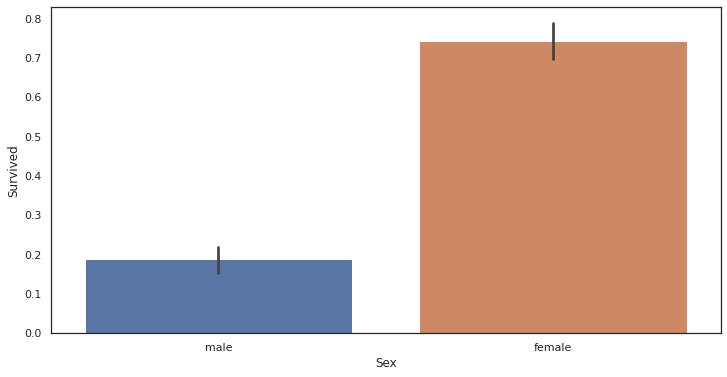

In [13]:
fig, ax = pyplot.subplots(figsize=(12,6))
print(train[["Sex","Survived"]].groupby(["Sex"],as_index=False).mean())
sns.barplot(x="Sex",y="Survived",data=train,ax=ax)

As we predicted,the survival rate for female passengers is **~0.74%** while survival rate for male passengers is **~0.19%**. This is an important consideration for our models and visualizations.

# 3.3.-Pclass Feature

Our prediction for this feature was that higher socio-economic status passengers tend to survive more than lower socio-economic status passengers.

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


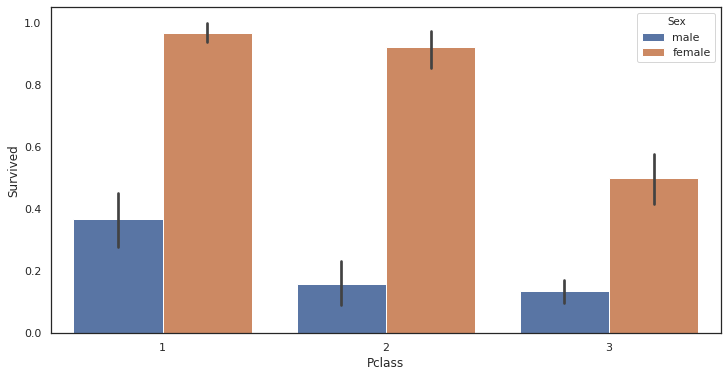

In [14]:
fig, ax = pyplot.subplots(figsize=(12,6))
print(train[["Pclass","Survived"]].groupby(["Pclass"],as_index=False).mean())
sns.barplot(x="Pclass",y="Survived",data=train,hue="Sex",ax=ax)

As we predicted, the survival rate for higher socio-economic status passengers was higher than for lower ones. **~0.63%** for first class, **~0.47%** for second class and **~0.24%** for third class.\

We can highlight that the great difference between male´s survival according to their socio-economic class is between the first and second class while for female passengers it´s between the second and third class since the survival rate of females for the first and second class is very similar

# 3.4.-Name Feature

In [15]:
percent_value_counts(train,"Name")

,Total,Percent
"Palsson, Miss. Torborg Danira",1,0.11
"Abelson, Mrs. Samuel (Hannah Wizosky)",1,0.11
"Navratil, Master. Michel M",1,0.11
"Cacic, Mr. Luka",1,0.11
"Harrington, Mr. Charles H",1,0.11
...,...,...
"Odahl, Mr. Nils Martin",1,0.11
"Drazenoic, Mr. Jozef",1,0.11
"Salonen, Mr. Johan Werner",1,0.11
"Chip, Mr. Chang",1,0.11


As this feature has no value for our model, we will try to get the title name for each passenger and drop the original feature

In [16]:
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Apply get_title function
train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

percent_value_counts(train,"Title")

,Total,Percent
Mr,517,58.02
Miss,182,20.43
Mrs,125,14.03
Master,40,4.49
Dr,7,0.79
Rev,6,0.67
Col,2,0.22
Mlle,2,0.22
Major,2,0.22
Capt,1,0.11


We still have so many titles so they cant be usefull for our model. Let´s try to reduce the categories.

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


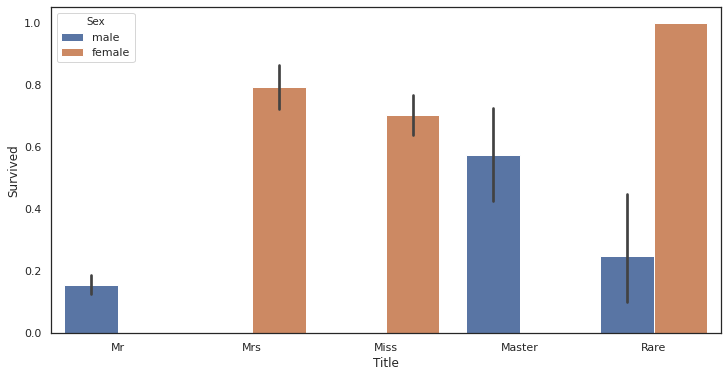

In [17]:
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

fig, ax = pyplot.subplots(figsize=(12,6))
print(train[['Title','Survived']].groupby(['Title'], as_index=False).mean())
sns.barplot(x="Title", y="Survived", data=train,hue="Sex",ax=ax)

Now we can appreciate better the survival rate for each name title where the female passengers and higher status passengers still has the higher survival rate.

Once we have this new feature we can drop the original one

In [18]:
train.drop(['Name'], axis=1, inplace=True)
test.drop(['Name'], axis=1, inplace=True)
train.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
414,1,3,male,44.0,0,0,STON/O 2. 3101269,7.9250,NaN,S,Mr
647,1,1,male,56.0,0,0,13213,35.5000,A26,C,Rare
756,0,3,male,28.0,0,0,350042,7.7958,NaN,S,Mr
759,1,1,female,33.0,0,0,110152,86.5000,B77,S,Rare
65,1,3,male,NaN,1,1,2661,15.2458,NaN,C,Master


# 3.5.-Age Feature

      Age  Survived
0    0.42       1.0
1    0.67       1.0
2    0.75       1.0
3    0.83       1.0
4    0.92       1.0
..    ...       ...
83  70.00       0.0
84  70.50       0.0
85  71.00       0.0
86  74.00       0.0
87  80.00       1.0

[88 rows x 2 columns]


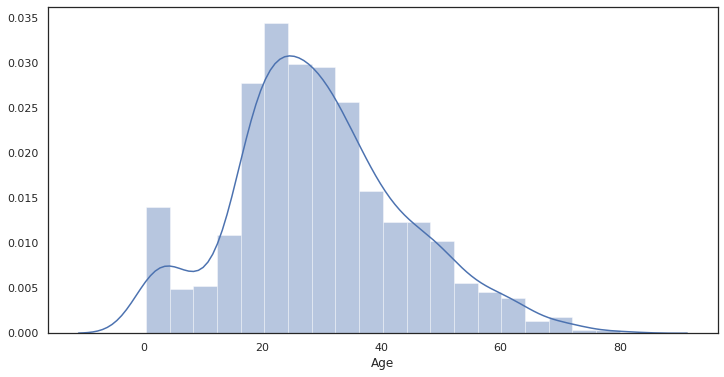

In [19]:
print(train[["Age","Survived"]].groupby(["Age"],as_index=False).mean())
fig, ax = pyplot.subplots(figsize=(12,6))
sns.distplot(train.Age,ax=ax)

As predicted, baby´s survival rate is higher maybe because they had preference in evacuating the ship

For making this feature usefull for our predictions we can create a new feature with age ranges.But first of all, as we have missing values in this feature, we will treat them like "unknown"

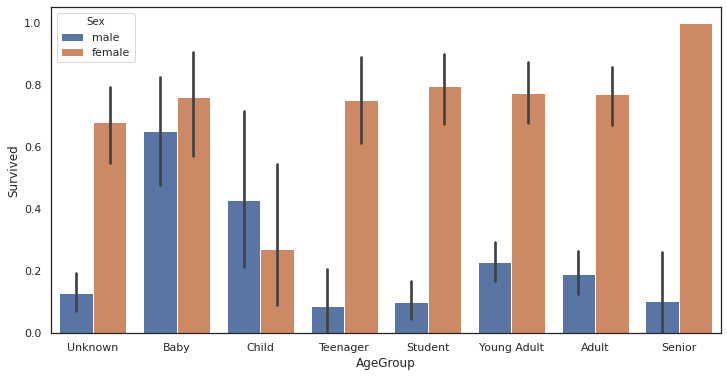

In [20]:
train["Age"] = train["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)

test["Age"] = test["Age"].fillna(-0.5)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)

fig, ax = pyplot.subplots(figsize=(12,6))
sns.barplot(x="AgeGroup", y="Survived", data=train,hue="Sex",ax=ax)

As we suposed, babies survival rate is high and surprisingly it´s almost the same for female and male babies

With this new feature we can drop the original one

In [21]:
train.drop(['Age'], axis=1, inplace=True)
test.drop(['Age'], axis=1, inplace=True)
train.sample(5)

,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup
61,1,1,female,0,0,113572,80.0000,B28,NaN,Miss,Adult
855,1,3,female,0,1,392091,9.3500,NaN,S,Mrs,Teenager
16,0,3,male,4,1,382652,29.1250,NaN,Q,Master,Baby
527,0,1,male,0,0,PC 17483,221.7792,C95,S,Mr,Unknown
485,0,3,female,3,1,4133,25.4667,NaN,S,Miss,Unknown


# 3.6.-SibSp Feature

   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


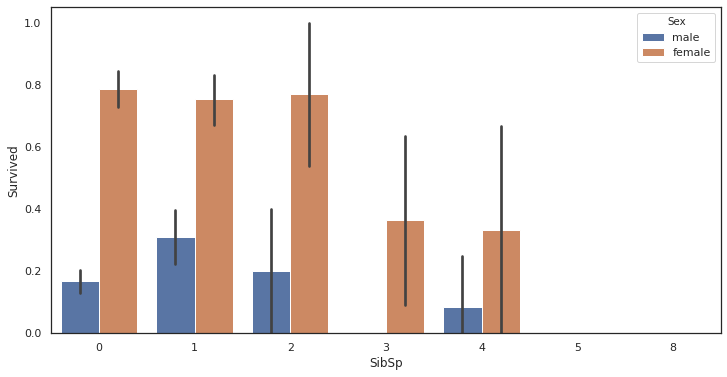

In [22]:
fig, ax = pyplot.subplots(figsize=(12,6))
print(train[["SibSp","Survived"]].groupby(["SibSp"],as_index=False).mean())
sns.barplot(x="SibSp",y="Survived",data=train,hue="Sex",ax=ax)

We can see how having a big family aboard, decreases the survival rate, but having one or two family members aboard increases the survival rate for male passengers

# 3.7.-Parch Feature

   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000


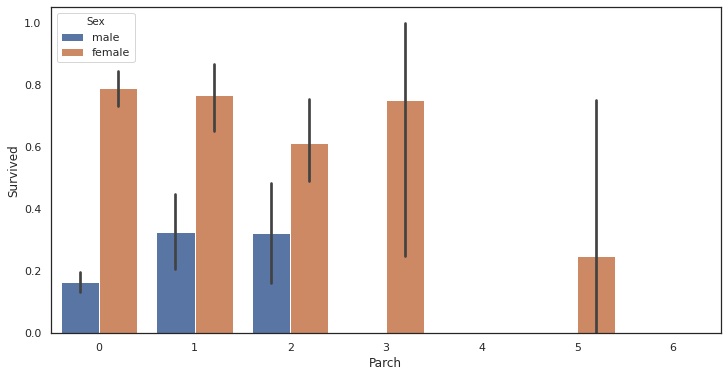

In [23]:
fig, ax = pyplot.subplots(figsize=(12,6))
print(train[["Parch","Survived"]].groupby(["Parch"],as_index=False).mean())
sns.barplot(x="Parch",y="Survived",data=train,hue="Sex",ax=ax)

As with the "SibSp" feature, we can see how having one or two children or parents increases the male survival rate

With the "SibSp" and "Parch" feature we can create new features as "FamilySize" or "IsAlone"

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


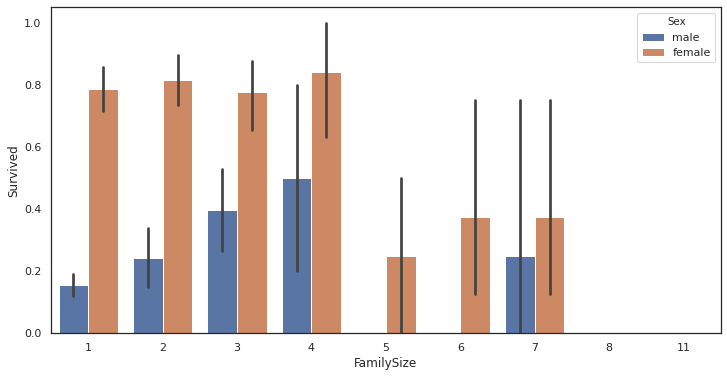

In [24]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
fig, ax = pyplot.subplots(figsize=(12,6))
print(train[["FamilySize","Survived"]].groupby(["FamilySize"],as_index=False).mean())
sns.barplot(x="FamilySize",y="Survived",data=train,ax=ax,hue="Sex")

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


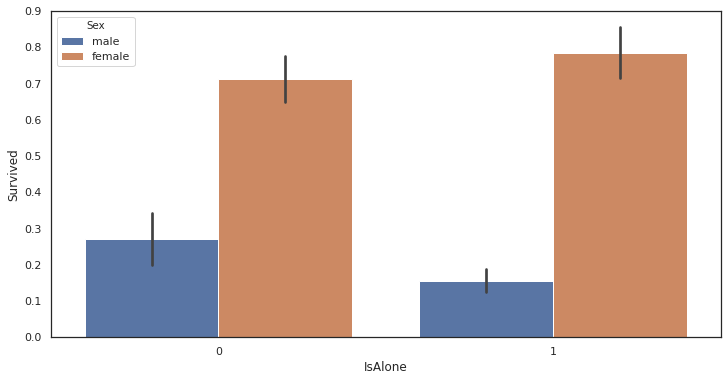

In [25]:
train["IsAlone"]=0
train.loc[train["FamilySize"] == 1,"IsAlone"]= 1

test["IsAlone"]=0
test.loc[test["FamilySize"] == 1,"IsAlone"]= 1

print(train[["IsAlone","Survived"]].groupby(["IsAlone"],as_index=False).mean())
fig, ax = pyplot.subplots(figsize=(12,6))
sns.barplot(x="IsAlone",y="Survived",data=train,ax=ax,hue="Sex")

# 3.8.-Ticket Feature

As this feature is alphanumerical and it depends on the embarking port, prices and more features we will drop this feature

In [26]:
train.drop(['Ticket'], axis=1, inplace=True)
test.drop(['Ticket'], axis=1, inplace=True)
train.sample(5)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Title,AgeGroup,FamilySize,IsAlone
113,0,3,female,1,0,9.825,NaN,S,Miss,Student,2,0
468,0,3,male,0,0,7.725,NaN,Q,Mr,Unknown,1,1
348,1,3,male,1,1,15.900,NaN,S,Master,Baby,3,0
636,0,3,male,0,0,7.925,NaN,S,Mr,Young Adult,1,1
196,0,3,male,0,0,7.750,NaN,Q,Mr,Unknown,1,1


# 3.9.-Fare Feature

         Fare  Survived
0      0.0000  0.066667
1      4.0125  0.000000
2      5.0000  0.000000
3      6.2375  0.000000
4      6.4375  0.000000
..        ...       ...
243  227.5250  0.750000
244  247.5208  0.500000
245  262.3750  1.000000
246  263.0000  0.500000
247  512.3292  1.000000

[248 rows x 2 columns]


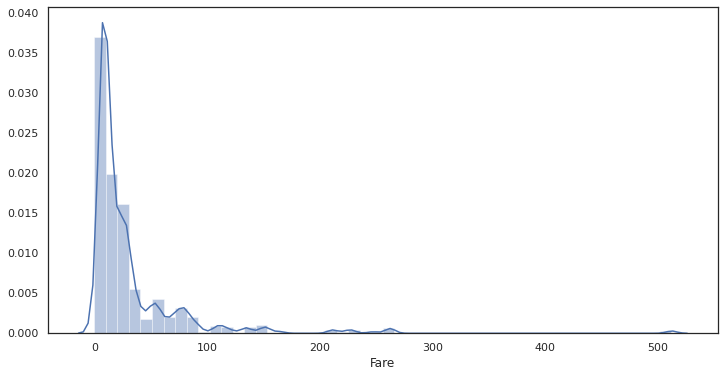

In [27]:
print(train[["Fare","Survived"]].groupby(["Fare"],as_index=False).mean())
fig, ax = pyplot.subplots(figsize=(12,6))
sns.distplot(train.Fare,ax=ax)

With this feature happens the same that with "Age" feature. We need to create fare ranges for creating a new feature.

  FareGroup  Survived
0         A  0.197309
1         B  0.303571
2         C  0.454955
3         D  0.581081
   Total  Percent
B    224    25.14
A    223    25.03
D    222    24.92
C    222    24.92
     Total  Percent
A      114    27.27
C      105    25.12
D      102    24.40
B       96    22.97
NaN      1     0.24


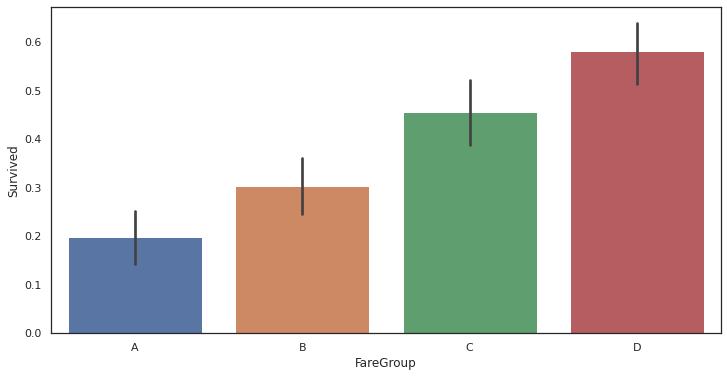

In [28]:
train['FareGroup'] = pd.qcut(train['Fare'], 4, labels=['A', 'B', 'C', 'D'])
test['FareGroup'] = pd.qcut(test['Fare'], 4, labels=['A', 'B', 'C', 'D'])
print(train[['FareGroup','Survived']].groupby(['FareGroup'], as_index=False).mean())
print(percent_value_counts(train,"FareGroup"))
print(percent_value_counts(test,"FareGroup"))

fig, ax = pyplot.subplots(figsize=(12,6))
sns.barplot(x="FareGroup",y="Survived",data=train,ax=ax)

We can appreciate that a more expensive ticket fare increases the survival rate of the passenger that buy it.

Now we can drop the original feature.

In [29]:
train.drop(['Fare'], axis=1, inplace=True)
test.drop(['Fare'], axis=1, inplace=True)
train.sample(5)

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Title,AgeGroup,FamilySize,IsAlone,FareGroup
303,1,2,female,0,0,E101,Q,Miss,Unknown,1,1,B
78,1,2,male,0,2,NaN,S,Master,Baby,3,0,C
669,1,1,female,1,0,C126,S,Mrs,Unknown,2,0,D
505,0,1,male,1,0,C65,C,Mr,Teenager,2,0,D
131,0,3,male,0,0,NaN,S,Mr,Student,1,1,A


We will inpute the missing value with the mode.

In [30]:
test["FareGroup"].fillna(("B"),inplace=True)

In [31]:
missing_percentage(test)

,Total,Percent
Cabin,327,78.23
FareGroup,0,0.00
IsAlone,0,0.00
FamilySize,0,0.00
AgeGroup,0,0.00
Title,0,0.00
Embarked,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00


# 3.10.-Cabin Feature

In [32]:
percent_value_counts(train,"Cabin")

,Total,Percent
NaN,687,77.10
C23 C25 C27,4,0.45
B96 B98,4,0.45
G6,4,0.45
F2,3,0.34
...,...,...
B30,1,0.11
F E69,1,0.11
C47,1,0.11
E38,1,0.11


In [33]:
pd.unique(train['Cabin'])

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

This feature is like the "Name" feature. We can extract the letter from the cabin as it indicates the area of the ship where the cabin is. Also we will extract the number of the cabin

For the missing values we will use "N"

In [34]:
train["Cabin_Data"] = train["Cabin"].isnull().apply(lambda x: not x)
test["Cabin_Data"] = test["Cabin"].isnull().apply(lambda x: not x)

train["Deck"] = train["Cabin"].str.slice(0,1)
train["Room"] = train["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
train["Deck"] = train["Deck"].fillna("N")
train["Room"] = round(train["Room"].fillna(train["Room"].mean()),0).astype("int")

test["Deck"] = test["Cabin"].str.slice(0,1)
test["Room"] = test["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
test["Deck"] = test["Deck"].fillna("N")
test["Room"] = round(test["Room"].fillna(test["Room"].mean()),0).astype("int")

train.sample(5)

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Title,AgeGroup,FamilySize,IsAlone,FareGroup,Cabin_Data,Deck,Room
432,1,2,female,1,0,NaN,S,Mrs,Adult,2,0,C,False,N,50
313,0,3,male,0,0,NaN,S,Mr,Young Adult,1,1,A,False,N,50
548,0,3,male,1,1,NaN,S,Mr,Young Adult,3,0,C,False,N,50
388,0,3,male,0,0,NaN,Q,Mr,Unknown,1,1,A,False,N,50
252,0,1,male,0,0,C87,S,Mr,Senior,1,1,C,True,C,87


In [35]:
percent_value_counts(train,"Deck")

,Total,Percent
N,687,77.10
C,59,6.62
B,47,5.27
D,33,3.70
E,32,3.59
A,15,1.68
F,13,1.46
G,4,0.45
T,1,0.11


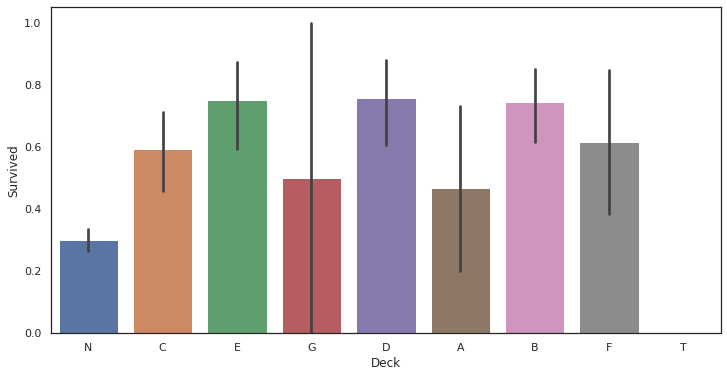

In [36]:
fig, ax = pyplot.subplots(figsize=(12,6))
sns.barplot(x="Deck", y="Survived", data=train,ax=ax)

In [37]:
train['Room'].describe()

count    891.000000
mean      50.109989
std       16.738075
min        2.000000
25%       50.000000
50%       50.000000
75%       50.000000
max      148.000000
Name: Room, dtype: float64

We need to divide the room feature by groups

In [38]:
bins = [0, 50, 75, 100,np.inf]
labels = ["g1","g2","g3","g4"]
train["RoomGroup"] = pd.cut(train["Room"], bins, labels = labels)
test["RoomGroup"] = pd.cut(test["Room"], bins, labels = labels)
train.sample(5)

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Title,AgeGroup,FamilySize,IsAlone,FareGroup,Cabin_Data,Deck,Room,RoomGroup
300,1,3,female,0,0,NaN,Q,Miss,Unknown,1,1,A,False,N,50,g1
90,0,3,male,0,0,NaN,S,Mr,Young Adult,1,1,B,False,N,50,g1
680,0,3,female,0,0,NaN,Q,Miss,Unknown,1,1,B,False,N,50,g1
207,1,3,male,0,0,NaN,C,Mr,Young Adult,1,1,C,False,N,50,g1
220,1,3,male,0,0,NaN,S,Mr,Teenager,1,1,B,False,N,50,g1


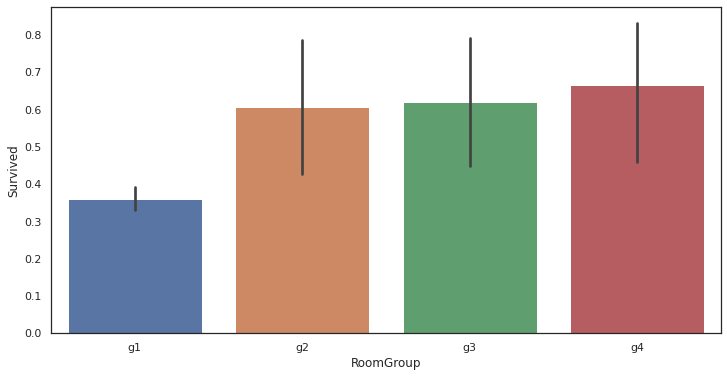

In [39]:
fig, ax = pyplot.subplots(figsize=(12,6))
sns.barplot(x="RoomGroup", y="Survived", data=train)

Now we can drop the original cabin feature, the temporal one and the numeric cabin feature

In [40]:
train.drop(["Cabin", "Cabin_Data", "Room"], axis=1, inplace=True)
test.drop(["Cabin", "Cabin_Data", "Room"], axis=1, inplace=True)
train.sample(5)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Title,AgeGroup,FamilySize,IsAlone,FareGroup,Deck,RoomGroup
349,0,3,male,0,0,S,Mr,Adult,1,1,B,N,g1
622,1,3,male,1,1,C,Mr,Student,3,0,C,N,g1
44,1,3,female,0,0,Q,Miss,Student,1,1,A,N,g1
151,1,1,female,1,0,S,Mrs,Student,2,0,D,C,g1
198,1,3,female,0,0,Q,Miss,Unknown,1,1,A,N,g1


# 3.11.-Embarked Feature

     Total  Percent
S      644    72.28
C      168    18.86
Q       77     8.64
NaN      2     0.22
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


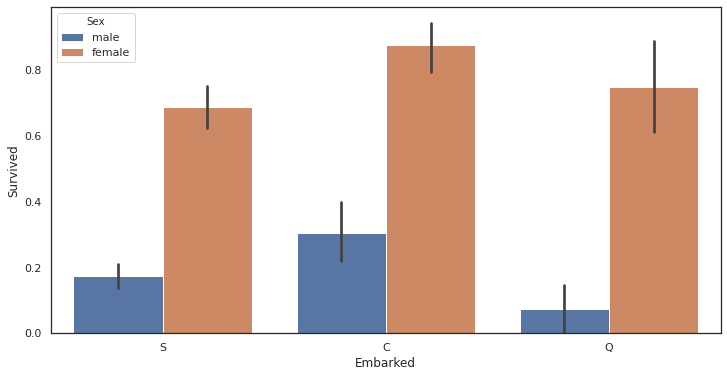

In [41]:
print(percent_value_counts(train,"Embarked"))
print(train[["Embarked","Survived"]].groupby(["Embarked"],as_index=False).mean())

fig, ax = pyplot.subplots(figsize=(12,6))
sns.barplot(x="Embarked",y="Survived",data=train,ax=ax,hue="Sex")

We can replace the two missing values with the mode that is Southampton and check if there are more missing values

In [42]:
train.Embarked.fillna("S", inplace=True)
missing_percentage(train)

,Total,Percent
RoomGroup,0,0.0
Deck,0,0.0
FareGroup,0,0.0
IsAlone,0,0.0
FamilySize,0,0.0
AgeGroup,0,0.0
Title,0,0.0
Embarked,0,0.0
Parch,0,0.0
SibSp,0,0.0


In [43]:
missing_percentage(test)

,Total,Percent
RoomGroup,0,0.0
Deck,0,0.0
FareGroup,0,0.0
IsAlone,0,0.0
FamilySize,0,0.0
AgeGroup,0,0.0
Title,0,0.0
Embarked,0,0.0
Parch,0,0.0
SibSp,0,0.0


# 4.-Preparing the Dataset for modeling

In this part we scale the numeric features and convert the categorical features into numeric features

In [44]:
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
y= train["Survived"]
predictors=["Pclass","Sex","SibSp","Parch","FamilySize","Embarked","IsAlone","FareGroup","Deck","RoomGroup","AgeGroup","Title"]
#i need to include here one more feature to test or i cant predict survival values
test["Survived"]=0
predictorst=["Pclass","Sex","SibSp","Parch","FamilySize","Embarked","IsAlone","FareGroup","Deck","RoomGroup","AgeGroup","Title","Survived"]


x=train[predictors]
x_test=test[predictorst]

x=pd.get_dummies(x)
x_test=pd.get_dummies(x_test)

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x=scale.fit_transform(x)
x_test=scale.fit_transform(x_test)

np.savez_compressed("np_savez_comp", X=x, y=y)
data = np.load("np_savez_comp.npz")

X = data["X"]
y = data["y"]

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# 5.-Modeling and Best Model Choice

## Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

with open('Naive Bayes.pickle', mode='wb') as fp:
    pickle.dump(gnb, fp)
    
score = gnb.score(X_valid, y_valid)
print('NB score: {}' .format(score))

NB score: 0.7597765363128491


## Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=0)
logistic_regression.fit(X_train, y_train)

with open('Logistic Regression.pickle', mode='wb') as fp:
    pickle.dump(logistic_regression, fp)

score = logistic_regression.score(X_valid, y_valid)
print('LR score: {}' .format(score))

LR score: 0.8156424581005587


## Support Vector Classifier

In [48]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train, y_train)

with open('Support Vector Machine.pickle', mode='wb') as fp:
    pickle.dump(svm, fp)
    
score = svm.score(X_valid, y_valid)
print('SVC linear score: {}' .format(score))


svm2 = SVC(kernel='rbf', C=1.0, random_state=0)
svm2.fit(X_train, y_train)
score = svm2.score(X_valid, y_valid)
print('SVC rbf score: {}' .format(score))

SVC linear score: 0.8044692737430168
SVC rbf score: 0.8212290502793296


## K Nearest Neighbor

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train, y_train)

with open('Nearest Neighbors.pickle', mode='wb') as fp:
    pickle.dump(knn, fp)
    
score = knn.score(X_valid, y_valid)
print('KNN score: {}' .format(score))

KNN score: 0.8100558659217877


## AdaBoost

In [50]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(algorithm='SAMME.R', random_state=0)
ada_boost.fit(X_train, y_train)

with open('Ada Boost.pickle', mode='wb') as fp:
    pickle.dump(ada_boost, fp)
    
score = ada_boost.score(X_valid, y_valid)
print('AB score: {}' .format(score))

AB score: 0.8268156424581006


## Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(criterion='entropy',random_state=0)
decision_tree.fit(X_train, y_train)

with open('Decision Tree.pickle', mode='wb') as fp:
    pickle.dump(decision_tree, fp)
    
score = decision_tree.score(X_valid, y_valid)
print('DT score: {}' .format(score))

DT score: 0.7988826815642458


## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100,random_state=0)
random_forest.fit(X_train, y_train)

with open('Random Forest.pickle', mode='wb') as fp:
    pickle.dump(random_forest, fp)
    
score = random_forest.score(X_valid, y_valid)
print('RF score: {}' .format(score))

RF score: 0.8491620111731844


## Extreme Gradient Boosting

In [53]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)
xgb.fit(X_train, y_train)

with open('Gradient Boosting.pickle', mode='wb') as fp:
    pickle.dump(xgb, fp)
    
score = xgb.score(X_valid, y_valid)
print('score: {}' .format(score))

score: 0.8156424581005587


## Best Model

In [54]:
names = ["Support Vector Machine", "Logistic Regression", "Nearest Neighbors",
         "Decision Tree","Random Forest", "Naive Bayes", "Ada Boost","Gradient Boosting"]

result = []
print("For guessing the Survived feature we used the following models:")
print(" ")
for name in names:
    with open(name + '.pickle', 'rb') as fp:
        clf = pickle.load(fp)
    
    clf.fit(X_train, y_train)
    score1 = clf.score(X_train, y_train)
    score2 = clf.score(X_valid, y_valid)
    result.append([score1, score2])
    
    print(name)

df_result = pd.DataFrame(result, columns=['Training', 'Validation'], index = names)
df_result.sort_values("Validation",ascending=False)

For guessing the Survived feature we used the following models:
 
Support Vector Machine
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Naive Bayes
Ada Boost
Gradient Boosting


,Training,Validation
Random Forest,0.928371,0.849162
Ada Boost,0.830056,0.826816
Logistic Regression,0.837079,0.815642
Gradient Boosting,0.869382,0.815642
Nearest Neighbors,0.853933,0.810056
Support Vector Machine,0.831461,0.804469
Decision Tree,0.928371,0.798883
Naive Bayes,0.755618,0.759777


As we can see the best model that fits our data is Random Forest so we will search the best params for it to make the prediction

## Searching the best params for Random Forest

In [55]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': [100],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}

grid_search = GridSearchCV(random_forest, params, cv=10, return_train_score=True)
best_grid = grid_search.fit(X_train,y_train)
best_grid

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 20, 25],
                         'max_features': ['auto', 'sqrt', 10],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3], 'n_estimators': [100]},
             return_train_score=True)

In [56]:
print('best score: {:0.3f}'.format(grid_search.score(X, y)))
print('best params: {}'.format(grid_search.best_params_))
print('best val score:  {:0.3f}'.format(grid_search.best_score_))

best score: 0.873
best params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
best val score:  0.836


In [57]:
test2=pd.read_csv("/kaggle/input/titanic/test.csv")
ids=test2["PassengerId"]
test.drop("Survived",axis=1,inplace=True)

In [58]:
best_model=RandomForestClassifier(n_estimators=100,bootstrap=True,criterion="gini",max_depth=15,max_features="auto",min_samples_leaf=2,min_samples_split=2)
best_model.fit(X_train,y_train)
preds=best_model.predict(x_test)

# 6.-Creating the Submission File

In [59]:
output = pd.DataFrame({ "PassengerId" : ids, "Survived": preds })
output.to_csv("submission.csv", index=False)

This is the end of my first data analysis in Kaggle. Remember you can give recomendations and tips in the comments! Hope you enjoyed it!

### Source:
   * [Titanic Project Example](https://www.kaggle.com/kenjee/titanic-project-example)
   * [Titanic Survival Predictions (Beginner)](https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner)    
   * [Various machine learning for beginners](https://www.kaggle.com/yanaitti/various-machine-learning-for-beginners)    